# Server Tips Analysis

### Importing libraries for data manipulation and visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset for manipulation and cleaning

In [2]:
day = pd.read_csv('day_shifts.csv')
night = pd.read_csv('night_shifts.csv')
doubles = pd.read_csv('double_shifts.csv')

# Dropping columns we do not need
day.drop(['Number of Covers', 'Average Check Amount', 'Total Number of Checks'], axis=1, inplace=True)
night.drop(['Number of Covers', 'Average Check Amount', 'Total Number of Checks'], axis=1, inplace=True)
doubles.drop(['Number of Covers', 'Average Check Amount', 'Total Number of Checks'], axis=1, inplace=True)

# Combine the day and night dataframes into a master dataset
day['Shift'] = 'Day'
night['Shift'] = 'Night'
shifts_worked = day.append(night)
shifts_worked.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 42
Data columns (total 5 columns):
Day            78 non-null object
Tips           78 non-null float64
Cash Amount    78 non-null float64
Sales          78 non-null float64
Shift          78 non-null object
dtypes: float64(3), object(2)
memory usage: 3.7+ KB


In [3]:
# Adding a new column of data, My Tips, Amount of tips a server yields after tipping out the kitchen and bar (6%)
# Assuming people who pay in cash tip in cash, randomized between 10 to 18%.
shifts_worked['My Tips'] = round(shifts_worked['Tips'] - (shifts_worked['Sales'] * 0.06) + (shifts_worked['Cash Amount'] * np.random.randint(10,19) / 100), 2)
shifts_worked.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 42
Data columns (total 6 columns):
Day            78 non-null object
Tips           78 non-null float64
Cash Amount    78 non-null float64
Sales          78 non-null float64
Shift          78 non-null object
My Tips        78 non-null float64
dtypes: float64(4), object(2)
memory usage: 4.3+ KB


### Extrapolating and Splitting Doubles Dataset into Day and Night

In [4]:
# Extrapolating doubles dataset using the Day and Night datasets to split double shifts worked into Day and Night
avg_day_tip = shifts_worked[shifts_worked['Shift'] == 'Day']['My Tips'].values.mean()
avg_night_tip = shifts_worked[shifts_worked['Shift'] == 'Night']['My Tips'].values.mean()
avg_night_tip / avg_day_tip

1.5092061207329184

In [5]:
# On average you can expect to make 54% more on a night shift compared to a day shift
ratio = avg_day_tip / (avg_day_tip + avg_night_tip)
ratio

0.39853242495196384

In [6]:
# Same as above for the Day and Night datasets adding a My Tips column
doubles['My Tips'] = round(doubles['Tips'] - (doubles['Sales'] * 0.06) + (doubles['Cash Amount'] * np.random.randint(10,16) / 100), 2)

# Split Doubles into Day and Night by using the Ratio above
day_multiplier = np.ones(np.shape(doubles['Tips'])) * ratio
night_multiplier = np.ones(np.shape(doubles['Tips'])) * (1-ratio)
doubles_day = doubles.copy(deep=True)
doubles_night = doubles.copy(deep=True)

# Extrapolate new datasets
doubles_day['Tips'] = round(doubles_day['Tips'] * day_multiplier, 2)
doubles_day['Cash Amount'] = round(doubles_day['Cash Amount'] * day_multiplier, 2)
doubles_day['Sales'] = round(doubles_day['Sales'] * day_multiplier, 2)
doubles_day['My Tips'] = round(doubles_day['My Tips'] * day_multiplier, 2)
doubles_night['Tips'] = round(doubles_night['Tips'] * night_multiplier, 2)
doubles_night['Cash Amount'] = round(doubles_night['Cash Amount'] * night_multiplier, 2)
doubles_night['Sales'] = round(doubles_night['Sales'] * night_multiplier, 2)
doubles_night['My Tips'] = round(doubles_night['My Tips'] * night_multiplier, 2)
doubles_day['Shift'] = 'Day'
doubles_night['Shift'] = 'Night'

# Append new datasets into the master dataset
shifts_worked = shifts_worked.append([doubles_day, doubles_night], sort=False)

In [7]:
# Sorting dataset by Shift and Day
days_transform = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
days_reverse = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
# Map Categorical column Day to numerical for sorting
shifts_worked['Days Sort'] = shifts_worked.Day.map(days_transform)
shifts_worked.sort_values(['Shift', 'Days Sort'], inplace=True)
shifts_worked.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 42
Data columns (total 7 columns):
Day            128 non-null object
Tips           128 non-null float64
Cash Amount    128 non-null float64
Sales          128 non-null float64
Shift          128 non-null object
My Tips        128 non-null float64
Days Sort      128 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 8.0+ KB


### Data Visualization and Analysis

In [8]:
# Group and Aggregate data for bar plot, by count and average
plot_data = shifts_worked.groupby(['Day', 'Shift']).agg({'Tips':'count', 'Sales':'mean', 'Days Sort':'mean', 'My Tips':'mean'}).sort_values('Days Sort').reset_index()
plot_data

,Day,Shift,Tips,Sales,Days Sort,My Tips
0,Monday,Day,11,565.873636,0,57.285455
1,Monday,Night,12,654.396667,0,65.920833
2,Tuesday,Day,15,521.032000,1,53.606000
3,Tuesday,Night,5,661.906000,1,66.642000
4,Wednesday,Day,15,469.636667,2,47.096000
5,Wednesday,Night,10,752.547000,2,73.311000
6,Thursday,Day,9,433.468889,3,44.374444
7,Thursday,Night,11,952.562727,3,93.271818
8,Friday,Day,8,581.381250,4,53.043750
9,Friday,Night,13,1064.471538,4,85.386154


In [9]:
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 6 columns):
Day          13 non-null object
Shift        13 non-null object
Tips         13 non-null int64
Sales        13 non-null float64
Days Sort    13 non-null int64
My Tips      13 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 704.0+ bytes


Text(0.5, 1.0, 'Number of Days Worked by Day of the Week and Shift')

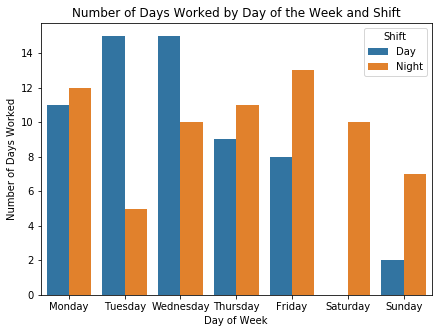

In [10]:
# Visualizing the frequency of days worked during the week by day and night using Seaborn Bar Plot
plt.figure(figsize=(7,5))
sns.barplot(x='Day', y='Tips',hue='Shift',data=plot_data)
plt.xlabel('Day of Week')
plt.ylabel('Number of Days Worked')
plt.title('Number of Days Worked by Day of the Week and Shift')

Text(0.5, 1.0, 'Average Sales Volume by Day of the Week and Shift')

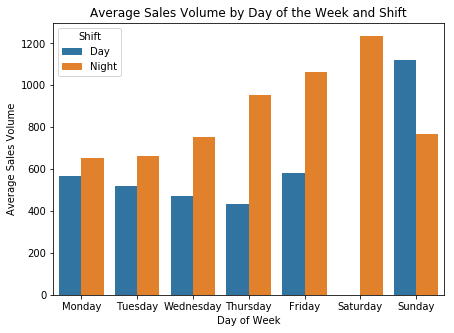

In [11]:
# Visualizing the Average Sales Volume by day and night using Seaborn Bar Plot
plt.figure(figsize=(7,5))
sns.barplot(x='Day', y='Sales',hue='Shift',data=plot_data)
plt.xlabel('Day of Week')
plt.ylabel('Average Sales Volume')
plt.title('Average Sales Volume by Day of the Week and Shift')

Text(0.5, 1.0, 'Linear Regression - My Tips vs. Average Sales')

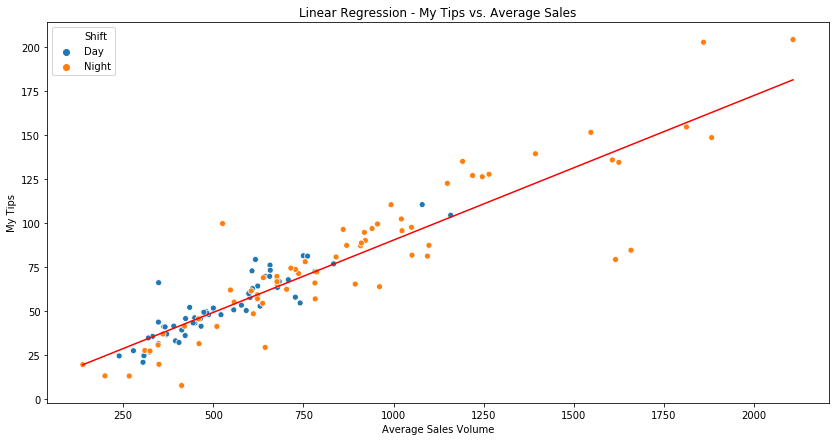

In [12]:
# Using NumPy and its linear algebra functions to fit a linear regression line of our data
mb = np.polyfit(shifts_worked['Sales'], shifts_worked['My Tips'], deg=1)
x = np.append(shifts_worked['Sales'].values.reshape(-1,1), np.ones(np.shape(shifts_worked['Sales'].values.reshape(-1,1))), axis=1)
y_pred = np.dot(x, mb)
# Visualizing the linear regression relationship between Average Sales Volume and Tips Received using Seaborn
plt.figure(figsize=(14,7))
sns.scatterplot(y='My Tips', x='Sales', hue='Shift', data=shifts_worked)
sns.lineplot(x='Sales', y=y_pred, data=shifts_worked, color='r')
plt.xlabel('Average Sales Volume')
plt.ylabel('My Tips')
plt.title('Linear Regression - My Tips vs. Average Sales')

In [13]:
# Transform and pivot our data to fit into a heatmap on Seaborn
pivoted = pd.pivot_table(shifts_worked, index=['Shift'], columns=['Days Sort', 'Day'], values=['My Tips'])
pivoted.sort_index(ascending=False, inplace=True)
pivoted.fillna(pivoted.iloc[1,:].mean(), inplace=True)
pivoted

My Tips                                                      \
Days Sort          0       1         2          3          4           5   
Day           Monday Tuesday Wednesday   Thursday     Friday    Saturday   
Shift                                                                      
Night      65.920833  66.642    73.311  93.271818  85.386154  114.004000   
Day        57.285455  53.606    47.096  44.374444  53.043750   60.483441   

                       
Days Sort           6  
Day            Sunday  
Shift                  
Night       48.407143  
Day        107.495000

In [14]:
pivoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, Night to Day
Data columns (total 7 columns):
(My Tips, 0, Monday)       2 non-null float64
(My Tips, 1, Tuesday)      2 non-null float64
(My Tips, 2, Wednesday)    2 non-null float64
(My Tips, 3, Thursday)     2 non-null float64
(My Tips, 4, Friday)       2 non-null float64
(My Tips, 5, Saturday)     2 non-null float64
(My Tips, 6, Sunday)       2 non-null float64
dtypes: float64(7)
memory usage: 208.0+ bytes


[Text(87.0, 0.5, 'Shift'),
 Text(0.5, 51.0, 'Day of the Week'),
 Text(0.5, 1.0, 'Average Tip Amount by Day of Week and Shift')]

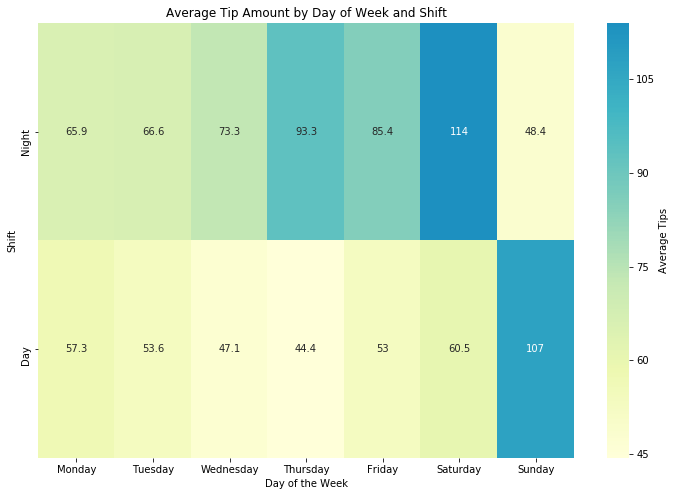

In [15]:
# Visualizing our Average tips earned by Day of the Week and Shift using Seaborn
plt.figure(figsize=(12,8))
ax = sns.heatmap(pivoted, annot=True, cmap='YlGnBu', fmt='.3g', center=100, xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], cbar_kws={'label': 'Average Tips'})
ax.set(xlabel='Day of the Week', ylabel='Shift', title='Average Tip Amount by Day of Week and Shift')